<a href="https://colab.research.google.com/github/1ho0jin1/SimSiam_ECE/blob/main/SimSiam_ECE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import easydict
import PIL.Image as Image
from scipy.optimize import linear_sum_assignment
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:',device)
!nvidia-smi

device: cuda:0
Tue Jan  5 05:32:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                         

# Data Preparation and Visualization

In [ ]:
label_dict = {
    0:"airplane",
    1:"automobile",
    2:"bird",
    3:"cat",
    4:"deer",
    5:"dog",
    6:"frog",
    7:"horse",
    8:"ship",
    9:"truck"
}

class CIFAR10_(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
            
        if self.transform is not None:
            img1 = self.transform(img)
            if self.train:
                img2 = self.transform(img)

        if self.train:
            return img1, img2, target, index
        else:
            return img1, target, index


# CIFAR10 mean, std
CIFAR_mean = torch.FloatTensor([0.4914, 0.4822, 0.4465])
CIFAR_std = torch.FloatTensor([0.2023, 0.1994, 0.2010])

totensor = transforms.ToTensor()
toimg = transforms.ToPILImage()

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2,1.)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_mean, std=CIFAR_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_mean, std=CIFAR_std),
])

unnorm = transforms.Normalize(mean=-CIFAR_mean/CIFAR_std, std=1/CIFAR_std)

# for SimSiam training
train_batch_size = 512
test_batch_size = 256
trainset = CIFAR10_(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10_(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, drop_last=True)

# for knn monitoring
bank_batch_size = 500
query_batch_size = 100
bankset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
queryset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
bankloader = torch.utils.data.DataLoader(bankset, batch_size=bank_batch_size, shuffle=False, drop_last=False)
queryloader = torch.utils.data.DataLoader(queryset, batch_size=query_batch_size, shuffle=False, drop_last=False)

# for classifier training : must shuffle trainset
classifier_trainloader = torch.utils.data.DataLoader(bankset,batch_size=bank_batch_size,shuffle=True,drop_last=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


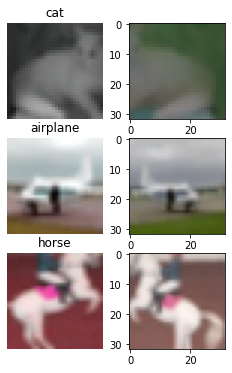

In [ ]:
x1,x2,label,_ = next(iter(trainloader))

idx = np.random.randint(0,len(x1)-4)
fig,ax = plt.subplots(3,2,figsize=(4,6))
for i in range(3):
  ax[i,0].imshow(unnorm(x1[i+idx]).permute(1,2,0))
  ax[i,1].imshow(unnorm(x2[i+idx]).permute(1,2,0))
  ax[i,0].set_title(label_dict[int(label[i+idx])])
  ax[i,0].axis('off')

# Model Architecture
1. Feature Extractor
- CNN : ResNet 18 (avg pool output: 512-dim)
- FC  : 512-2048-2048 (2-layer projection MLP)

* note that pre-activation resnet is used  
code from: https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.py

2. Predictor
- FC : 2048 - 512 - 2048 bottleneck structure

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(BasicBlock,self).__init__()
    self.stride = stride
    self.relu = nn.ReLU(inplace=True)
    self.bn1 = nn.BatchNorm2d(in_ch)
    self.conv1 = nn.Conv2d(in_ch,out_ch,kernel_size=3,stride=stride,padding=1)
    self.bn2 = nn.BatchNorm2d(out_ch)
    self.conv2 = nn.Conv2d(out_ch,out_ch,kernel_size=3,stride=1,padding=1)
    if stride != 1:
      self.shortcut = nn.Conv2d(in_ch,out_ch,kernel_size=1,stride=stride)

  def forward(self,x):
    out = self.bn1(x)
    out = self.relu(out)
    shortcut = self.shortcut(out) if hasattr(self,'shortcut') else x
    out = self.conv1(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv2(out)
    out += shortcut
    return out

class pre_resnet18(nn.Module):
  def __init__(self):
    super(pre_resnet18,self).__init__()
    self.cnn = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
    self.blk1 = nn.Sequential(
        BasicBlock(64,64,stride=1),
        BasicBlock(64,64,stride=1),
    )
    self.blk2 = nn.Sequential(
        BasicBlock(64,128,stride=2),
        BasicBlock(128,128,stride=1),
    )
    self.blk3 = nn.Sequential(
        BasicBlock(128,256,stride=2),
        BasicBlock(256,256,stride=1),
    )
    self.blk4 = nn.Sequential(
        BasicBlock(256,512,stride=2),
        BasicBlock(512,512,stride=1),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,10)


    # initialize conv >> follows Pytorch default initialization!
    """
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
    """

  def forward(self,x):
    out = self.cnn(x)
    out = self.blk1(out)
    out = self.blk2(out)
    out = self.blk3(out)
    out = self.blk4(out)
    out = self.avgpool(out)
    out = out.view(out.shape[0],-1)
    out = self.fc(out)
    return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])


class SimSiam_CIFAR(nn.Module):
  def __init__(self):
    super(SimSiam_CIFAR,self).__init__()
    # Projector
    self.projector = PreActResNet18()
    self.projector.linear = nn.Sequential(
                  nn.Linear(512,2048),
                  nn.BatchNorm1d(2048),
                  nn.ReLU(),
                  nn.Linear(2048,2048),
                  nn.BatchNorm1d(2048),
    )

    # Predictor : get rid of output BN (sec 4.4)
    self.predictor = nn.Sequential(
                  nn.Linear(2048,512),
                  nn.BatchNorm1d(512),
                  nn.ReLU(),
                  nn.Linear(512,2048),
    )

  def forward(self, x1, x2=None):
    if self.training:
      # projections
      z1,z2 = self.projector(x1), self.projector(x2)
      # predictions
      p1,p2 = self.predictor(z1), self.predictor(z2)
      return z1,z2,p1,p2
    
    # eval mode: single image input, single feature output
    else:
      assert x2 == None
      return self.projector(x1)

# Negative Cosine Similarity
def D(p,z):
  """
  z = z.detach()
  p = F.normalize(p,p=2,dim=1)
  z = F.normalize(z,p=2,dim=1)
  return -(p*z).sum(dim=1).mean()
  """
  # "faster version" by Patrick Hua (actually faster...?)
  return - F.cosine_similarity(p, z.detach(), dim=-1).mean()


# kNN monitoring function
"""
1. set model as eval mode
2. calculate feature bank V from all 50000 training images >> (50000,2048)
3. calculate features of all 10000 test images (queries) >> (10000,2048)
4. calculate similarity scores using softmax >> (10000, 50000)
5. using knn (k=200), get label predictions
** when calculating feature bank, get rid of augmentation **
"""
def knn_monitor(model, bankloader, queryloader, k=200, t=0.1):
  model.eval()
  V = torch.zeros(50000,2048)
  Q = torch.zeros(10000,2048)
  train_label = torch.zeros(50000).type(torch.LongTensor)
  test_label = torch.zeros(10000).type(torch.LongTensor)
  
  cnt = 0
  for img, label in bankloader:
    B = img.shape[0]
    img = img.to(device)
    v = model(img,None).detach()    # detach() to save memory
    V[cnt:cnt+B] = v
    train_label[cnt:cnt+B] = label
    cnt += B
  assert cnt == 50000

  cnt = 0
  for img, label in queryloader:
    B = img.shape[0]
    img = img.to(device)
    q = model(img,None).detach()    # detach() to save memory
    Q[cnt:cnt+B] = q
    test_label[cnt:cnt+B] = label
    cnt += B
  assert cnt == 10000

  # similarity score of Q w.r.t. V
  sim_score = F.softmax(torch.mm(Q,V.T)/t,dim=1)    # (10000,50000)

  # knn : k features with highest similarity
  # torch.topk : returns val, idx >> get idx: index of training sample w/ highest similarity
  # torch.mode : returns val, idx >> get val: most voted label
  _, k_idx = torch.topk(sim_score,k)    # (10000,k)
  pred, _ = torch.mode(train_label[k_idx],dim=1)    # 10000

  # get back to train mode
  model.train() 

  return torch.sum(pred == test_label), len(test_label)


def get_lr(optimizer):
  return optimizer.param_groups[0]['lr']

def save_chkpt(model,optimizer,scheduler,epoch,loss_hist,knn_hist,save_dir):
  state_dict = {
      "model_state_dict":model.state_dict(),
      "optim_state_dict":optimizer.state_dict(),
      "scheduler_state_dict":scheduler.state_dict(),
      "epoch":epoch,
      "history":(loss_hist,knn_hist)
  }
  torch.save(state_dict,save_dir)

In [ ]:
model = SimSiam_CIFAR().to(device)

epochs = 800
lr = 0.03
momentum = 0.9
weight_decay = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [ ]:
loss_hist = []
knn_hist = []
start_time = time.time()
best_acc = 0
for epoch in range(saved_epoch,epochs):
  epoch_time = time.time()

  for b,(x1,x2,label,_) in enumerate(trainloader):
    x1 = x1.to(device)
    x2 = x2.to(device)

    optimizer.zero_grad()
    z1,z2,p1,p2 = model(x1,x2)
    loss = D(p1,z2)/2 + D(p2,z1)/2
    loss.backward()
    optimizer.step()

    if b%30 == 0:
      loss_hist.append(loss.item())
      now = datetime.datetime.now()
      print("epoch:{} batch:{} loss:{:.4f} lr:{:.2e} time:{}".format(epoch, b, loss.item(), get_lr(optimizer), now.strftime('%Y-%m-%d %H:%M:%S')))
  
  # adjust lr by cosine annealing
  scheduler.step()
  correct,total = knn_monitor(model,bankloader,queryloader)
  accuracy = correct/total*100
  knn_hist.append(accuracy)
  print("epoch:{} knn_acc:{:.2f}% ({}/{}) epoch_time:{:.2f}\n".format(epoch,accuracy,correct,total,time.time()-epoch_time))
  if accuracy > best_acc:
    save_dir = "./SimSiam_pre_{}.chkpt".format(int(accuracy*100))
    save_chkpt(model,optimizer,scheduler,epoch,loss_hist,knn_hist,save_dir)
    best_acc = accuracy
    print("---------------- model saved: {:.2f}% ----------------".format(accuracy))

# Linear Evaluation

In [ ]:
classifier = nn.Linear(2048,10).to(device)
optimizer = optim.SGD(classifier.parameters(),lr=1,momentum=0.9,weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.1,patience=10)
criterion = nn.CrossEntropyLoss()

In [ ]:
#training classifier
classifier_loss_hist = []
classifier_acc_hist = []
best_acc = 20
for epoch in range(200):
  model.eval()
  epoch_time = time.time()
  if get_lr(optimizer) < 1e-3:
    print("training finished due to accuracy stall")
    break

  for batch, (img,label) in enumerate(classifier_trainloader):
    img, label = img.to(device), label.to(device)
    optimizer.zero_grad()

    with torch.no_grad():
      feature = model(img,None)
    pred = classifier(feature)
    loss = criterion(pred,label)
    loss.backward()
    optimizer.step()
    if batch%40 == 0:
      classifier_loss_hist.append(loss.item())
      now = datetime.datetime.now()
      print("epoch:{} batch:{} loss:{:.4f} lr:{:.2e} time:{}".format(epoch, batch, loss.item(), get_lr(optimizer), now.strftime('%Y-%m-%d %H:%M:%S')))

  correct = 0
  with torch.no_grad():
    for batch, (img,label) in enumerate(queryloader):
      img,label = img.to(device), label.to(device)
      feature = model(img,None)
      pred = classifier(feature)
      correct += torch.sum(torch.argmax(pred,dim=1) == label)
    accuracy = correct/100.
    classifier_acc_hist.append(accuracy)
    print("epoch:{} accuracy:{:.2f}% ({}/{})\n".format(epoch,accuracy,correct,10000))

  scheduler.step(accuracy)
  if accuracy > best_acc:
    best_acc = accuracy
    torch.save(classifier.state_dict(),"./classifier_largelr.pth")
    print("---------------- classifier saved: {:.2f}% ----------------\n".format(accuracy))

In [ ]:
# Mount from google drive
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load state dict
base_dir = "/content/drive/My Drive/MSLAB/SimSiam/"
simsiam_dir = "SimSiam_pre_8635.chkpt"
classifier_dir = "SimSiam_classifier_8490.pth"

chkpt = torch.load(base_dir+simsiam_dir)
model.load_state_dict(chkpt["model_state_dict"])
classifier.load_state_dict(torch.load(base_dir+classifier_dir))

<All keys matched successfully>

# ECE Calculation & Reliability Diagram

In [ ]:
class calib_metrics():
  def __init__(self,targets,dataloader,model):
    self.targets = targets
    self.logits = self.get_logits(dataloader,model)


  def get_logits(self,dataloader,model):
    N = len(self.targets)
    logits = torch.zeros(N,10)
    with torch.no_grad():
      n = 0
      for img,label in dataloader:
        img,label = img.to(device),label.to(device)
        b = len(label)
        logits[n:n+b] = model(img)
        n+=b
    assert n == N
    return logits


  def make_bins(self,M):
    bins = {}
    prev = 0
    conf,pred = torch.max(F.softmax(self.logits,dim=1),dim=1)
    for m,i in enumerate(torch.linspace(0,1,M+1)):
      if m==0: continue
      idx = (conf>=prev)*(conf<i)
      bins[m-1] = torch.where(idx==True)[0]
      prev = i
    return bins


  def ECE(self,M):
    ece = 0
    conf,pred = torch.max(F.softmax(self.logits,dim=1),dim=1)
    bins = self.make_bins(M)
    for m in range(M):
      indices = bins[m]
      bin_size = len(indices)
      if bin_size == 0: continue
      bin_acc = torch.sum(pred[indices] == self.targets[indices])
      bin_conf = torch.sum(conf[indices])
      ece += torch.abs(bin_acc-bin_conf)
    ece /= len(self.targets)
    return ece


  def ACC(self,M):
    acc_hist = []
    _,pred = torch.max(F.softmax(self.logits,dim=1),dim=1)
    bins = self.make_bins(M)
    for m in range(M):
      indices = bins[m]
      bin_size = len(indices)
      if bin_size == 0:
        acc_hist.append(0)
        continue
      acc = torch.sum(pred[indices] == self.targets[indices])/bin_size
      acc_hist.append(acc.item())
    return acc_hist

  def reliability_diagram(self,M):
    acc_hist = self.ACC(M)
    plt.figure(figsize=(4,4))
    plt.bar(torch.arange(0,M)+0.5,acc_hist)
    plt.xticks(torch.arange(0,M+1),["{:.2f}".format(i/M) for i in range(M+1)],rotation="vertical")
    plt.title("Reliability Diagram (M={})".format(M))
    plt.xlabel("confidence")
    plt.ylabel("accuracy")
    plt.show()

ECE:52.08%


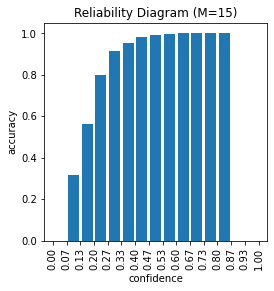

In [ ]:
net = nn.Sequential(model.eval(),classifier)
targets = torch.LongTensor(queryset.targets)
metrics = calib_metrics(targets,queryloader,net)

print("ECE:{:.2f}%".format(metrics.ECE(M=15).item()*100))
metrics.reliability_diagram(M=15)

# Temperature Scaling (Platt Scaling)
* Code from : https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py

In [ ]:
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [ ]:
net_temp = ModelWithTemperature(net).set_temperature(queryloader)

Before temperature - NLL: 1.262, ECE: 0.521
Optimal temperature: 0.089
After temperature - NLL: 0.800, ECE: 0.102


ECE:10.02%


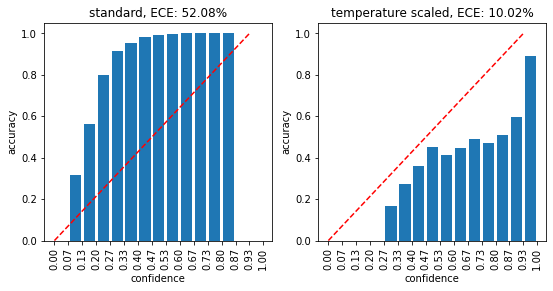

In [ ]:
metrics_temp = calib_metrics(targets,queryloader,net_temp)
print("ECE:{:.2f}%".format(temp_scaled_metrics.ECE(M=15).item()*100))

M=15
ece_list = [metrics.ECE(M),metrics_temp.ECE(M)]
acc_list = [metrics.ACC(M),metrics_temp.ACC(M)]
ttl_list = ["standard","temperature scaled"]

fig,ax = plt.subplots(1,2,figsize=(9,4))
for i in range(2):
  ax[i].bar(torch.arange(0,M)+0.5,acc_list[i])
  ax[i].set_xticks(torch.arange(0,M+1))
  ax[i].set_xticklabels(["{:.2f}".format(i/M) for i in range(M+1)],rotation="vertical")
  ax[i].set_title(ttl_list[i]+", ECE: {:.2f}%".format(ece_list[i].item()*100))
  ax[i].set_xlabel("confidence")
  ax[i].set_ylabel("accuracy")
  ax[i].plot(torch.linspace(0,1,M),c='r',linestyle='--')